[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.sandbox.google.com/github/kornia/tutorials/blob/master/nbs/image_matching_adalam.ipynb)

# Image matching example with KeyNet-AdaLAM

First, we will install everything needed:


*  fresh version of [kornia](https://github.com/kornia/kornia) for [AdaLAM](https://arxiv.org/abs/2006.04250)
*  fresh version of OpenCV for MAGSAC++ geometry estimation
*  [kornia_moons](https://ducha-aiki.github.io/kornia_moons) for the conversions and visualization

Docs: [`match_adalam`](https://kornia.readthedocs.io/en/latest/feature.html#kornia.feature.match_adalam)


In [ ]:
%%capture
!pip install git+https://github.com/kornia/kornia
!pip install kornia_moons
!pip install opencv-python --upgrade

Now let's download an image pair


In [ ]:
import io

import requests


def download_image(url: str, filename: str = "") -> str:
    filename = url.split("/")[-1] if len(filename) == 0 else filename
    # Download
    bytesio = io.BytesIO(requests.get(url).content)
    # Save file
    with open(filename, "wb") as outfile:
        outfile.write(bytesio.getbuffer())

    return filename


url_a = "https://github.com/kornia/data/raw/main/matching/kn_church-2.jpg"
url_b = "https://github.com/kornia/data/raw/main/matching/kn_church-8.jpg"
download_image(url_a)
download_image(url_b)

'kn_church-8.jpg'

First, imports.

In [ ]:
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import numpy as np
import torch
from kornia_moons.viz import *


def load_torch_image(fname):
    img = K.image_to_tensor(cv2.imread(fname), False).float() / 255.0
    img = K.color.bgr_to_rgb(img)
    return img


# device = K.utils.get_cuda_device_if_available()
device = torch.device("cpu")

In [ ]:
%%capture
fname1 = "kn_church-2.jpg"
fname2 = "kn_church-8.jpg"

img1 = load_torch_image(fname1)
img2 = load_torch_image(fname2)


feature = KF.KeyNetAffNetHardNet(5000, True).eval().to(device)

input_dict = {
    "image0": K.color.rgb_to_grayscale(img1),  # LofTR works on grayscale images only
    "image1": K.color.rgb_to_grayscale(img2),
}

hw1 = torch.tensor(img1.shape[2:])
hw2 = torch.tensor(img1.shape[2:])

adalam_config = {"device": device}

with torch.inference_mode():
    lafs1, resps1, descs1 = feature(K.color.rgb_to_grayscale(img1))
    lafs2, resps2, descs2 = feature(K.color.rgb_to_grayscale(img2))
    dists, idxs = KF.match_adalam(
        descs1.squeeze(0),
        descs2.squeeze(0),
        lafs1,
        lafs2,  # Adalam takes into account also geometric information
        config=adalam_config,
        hw1=hw1,
        hw2=hw2,  # Adalam also benefits from knowing image size
    )

In [ ]:
print(f"{idxs.shape[0]} tentative matches with AdaLAM")

393 tentative matches with AdaLAM


In [ ]:
def get_matching_keypoints(lafs1, lafs2, idxs):
    mkpts1 = KF.get_laf_center(lafs1).squeeze()[idxs[:, 0]].detach().cpu().numpy()
    mkpts2 = KF.get_laf_center(lafs2).squeeze()[idxs[:, 1]].detach().cpu().numpy()
    return mkpts1, mkpts2


mkpts1, mkpts2 = get_matching_keypoints(lafs1, lafs2, idxs)

Fm, inliers = cv2.findFundamentalMat(mkpts1, mkpts2, cv2.USAC_MAGSAC, 0.75, 0.999, 100000)
inliers = inliers > 0
print(f"{inliers.sum()} inliers with AdaLAM")

179 inliers with AdaLAM


Let's draw the inliers in green and tentative correspondences in yellow

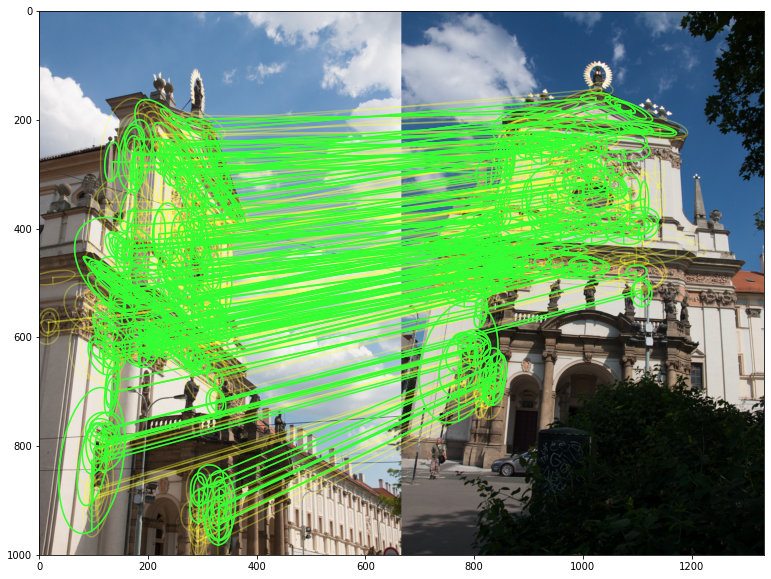

In [ ]:
draw_LAF_matches(
    lafs1,
    lafs2,
    idxs,
    K.tensor_to_image(img1),
    K.tensor_to_image(img2),
    inliers,
    draw_dict={"inlier_color": (0.2, 1, 0.2), "tentative_color": (1, 1, 0.2, 0.3), "feature_color": None, "vertical": False},
)